In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics_R
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points    = 0
Title         = 'Synthetic Regression'
FUR_Weight    = 0.5
N_consistancy = 25
consist_bound = 0.3

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.5, 0.5]


In [4]:
Title = Title + ' W:'+ str(FUR_Weight)

In [5]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Synthetic_Reg', Feature_Counts=[16,12])

#Reg_Data.df().head()

In [6]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.027280457677862247


MLPRegressor(random_state=RandomState(MT19937) at 0x2437FA89840)

In [7]:
Reg_Data.Random_Forest()

0.022530863803861823


RandomForestRegressor(random_state=RandomState(MT19937) at 0x2437FA89840)

In [8]:
Reg_Data.GP()

-3.746196050509341


GaussianProcessRegressor()

In [9]:
Reg_Data.L_Regression()

0.015108191617764666


LinearRegression()

In [10]:
print(Reg_Data.get_features())

['Passive_0', 'Passive_1', 'Active_2', 'Active_3', 'Active_4', 'Active_5', 'Active_6', 'Active_7']


In [11]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [12]:
#I2nd explainer object
URM_Exp_2 = UR_Model(bbox_model           = Reg_Data.get_L_Regression(),
                     train_data           = X_train,
                     feature_names        = Reg_Data.get_features(),
                     categorical_features = Reg_Data.get_catagorical(),
                     mode                 = Reg_Data.get_mode(),
                     sampling_optimize    = "opt")



In [13]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [16.97651604 16.72164301 17.30060039 16.92544072  9.04366245  5.66653926
 -8.83461112 14.37875821]
Std 0:  [3.26279151 2.17322648 2.89661398 1.72567148 5.17127089 1.87722983
 1.64589303 3.19351282]


In [14]:
# Generate explantion data for Random Forest

Reg_Stats   = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std(),
                                   N_consistancy = N_consistancy)

Reg_Stats_2 = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std())


if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    consistancy = URM_Exp.Y_Consistancy(N_points = N_consistancy, std_bound = consist_bound)
    
    URM_Exp.del_1_rel()
    
    del_1_var = URM_Exp.get_del_1_variance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         consistancy   = consistancy,
                         del_1_var     = del_1_var)
    
    
    ############################################################################################
    
    URM_Exp_2.explain(X_init      = data_row.reshape(1, -1),
                      Dimension   = 'Multi D',
                      kernel_type = "Matern",
                      max_iter    = 20,
                      alpha       = "FUR_W",
                      #jitter=5,
                      interval    = 1,
                      weight      = FUR_Weight)
       
    f_predict = Reg_Data.get_L_Regression().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp_2.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    scores = URM_Exp_2.permutation_importance()
    
    Reg_Stats_2.Add_Sample(sample_scores = scores,
                           outcome       = y_test[test_instance],
                           X_row         = data_row.reshape(1, -1),
                           f_prediction  = f_predict,
                           e_prediction  = e_predict.ravel(),
                           feopt         = None)
    


INSTANCE:  0
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[-102.14544534] [-1.02145445e+02  1.00000004e-05] [-102.14544536]
Acq_Data_nD
INSTANCE:  1
Acq_Data_nD
[-136.66546355] [-1.36665464e+02  1.00000004e-05] [-136.66546373]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  2
Acq_Data_nD
[-111.20270634] [-1.11202706e+02  1.00000004e-05] [-111.20270634]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  3
Acq_Data_nD
[-121.93561855] [-1.21935619e+02  1.00000004e-05] [-121.93561859]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  4
Acq_Data_nD
[-142.97809757] [-1.42978098e+02  1.00000004e-05] [-142.97809768]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [15]:
import matplotlib.pyplot as plt


In [16]:
print(f_predict)
print(e_predict)


[-144.19971526]
[-1.44199715e+02  9.99930650e-06]


In [17]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


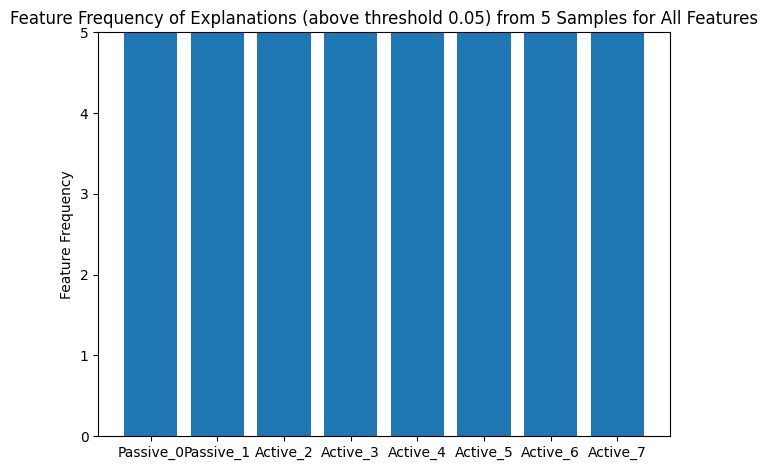

In [18]:
Reg_Stats.Frequency_Plot()


Average, SD, and Max Differences:
y - BB(x):           48.90189113530998  :  25.93958523982716  :  85.81976827845894
y - exp(x):          48.90189112531823  :  25.939585179638414  :  85.81976827716412
BB(x) - exp(x):      7.174392351316783e-08  :  6.766522892416754e-08  :  1.8390122136224818e-07
Average exp(x) Uncertainty:  1.0000000413701846e-05
R Score:   1.0
Fidelity:  1.0


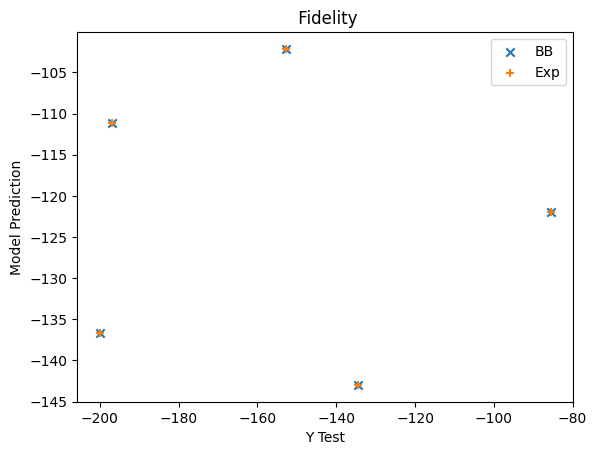

In [19]:
Reg_Stats.Fidelity()

In [20]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0


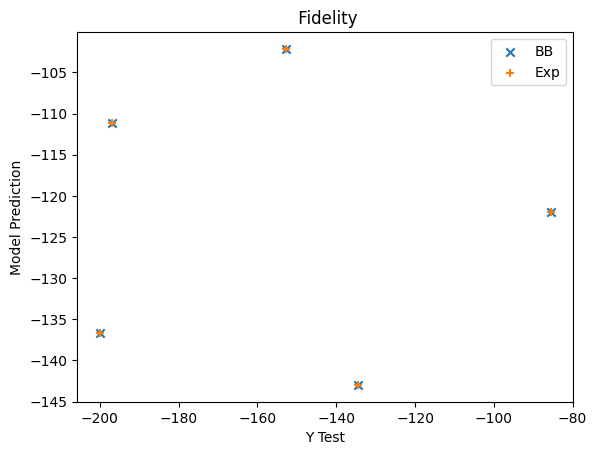

In [21]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (5, 8)


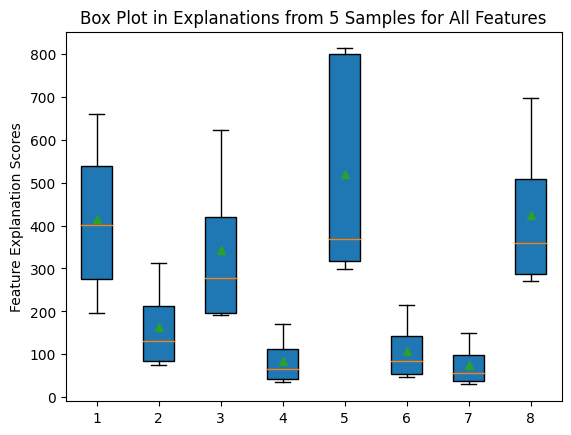

1 -      Passive_0
2 -      Passive_1
3 -      Active_2
4 -      Active_3
5 -      Active_4
6 -      Active_5
7 -      Active_6
8 -      Active_7


In [22]:
Reg_Stats.Box_Plot()


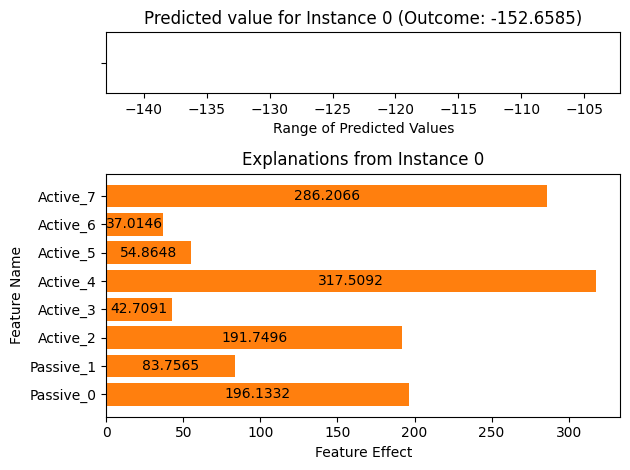

In [23]:
Reg_Stats.View_Explanation(instance = 0)

In [24]:
scores = URM_Exp.permutation_importance()
    
print(scores)

[329.44825115  98.80554255 225.92819172  47.25335385 311.94207608
  62.16908121  40.40952177 287.84837065]


In [25]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[7.93729322 6.43652019 7.19557112 6.26201637 9.89817508 6.3135089
 6.23800936 7.71945503]


In [26]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[64.30355632 46.67195178 52.51832381 43.85334522 66.62315594 44.71571996
 43.43571304 58.93575855]


In [27]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[1.18394639 1.17717856 1.07865988 1.17712429 0.89573223 0.6082359
 0.78336576 1.09575698]


In [28]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[6.37863484e-02 5.85976309e-04 3.46818753e-04 3.57648427e-04
 7.89866882e+00 4.46244464e-04 3.11112487e-04 3.54970283e-02]


In [29]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[ 7.18940547e+02 -5.37811080e+05  4.76792628e+03 -4.11590347e+06
  1.30676423e+01  2.74731812e+06  1.88020390e+06  1.04364485e+03]


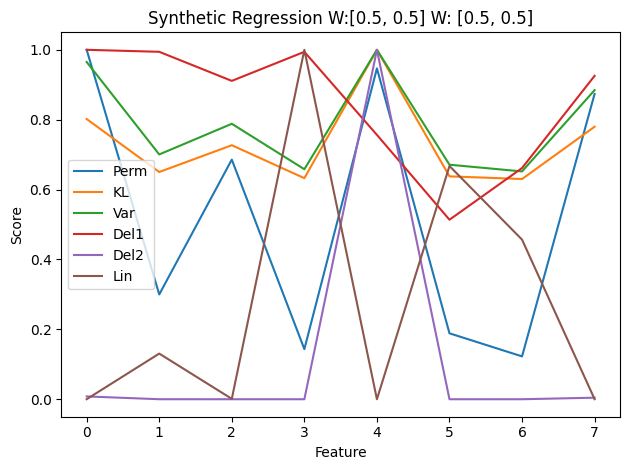

In [30]:
URM_Exp.plot_scores(Title)

In [31]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.97063705e-01  9.80390686e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.57650081e-01 -1.82705756e-02  9.87326004e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [32]:
acq_data.Create_BB_plot()

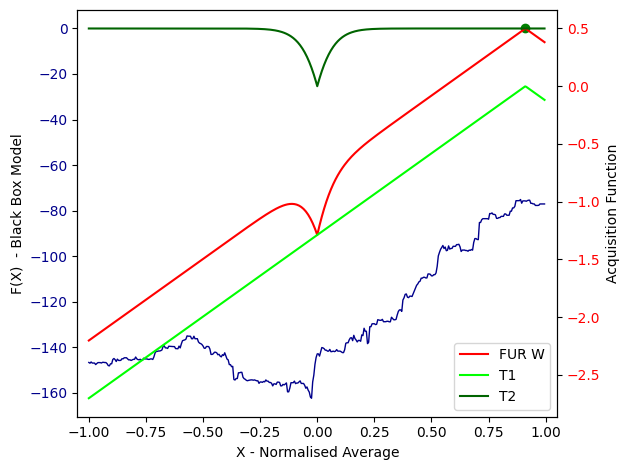

In [33]:
acq_data.plot_point(0)

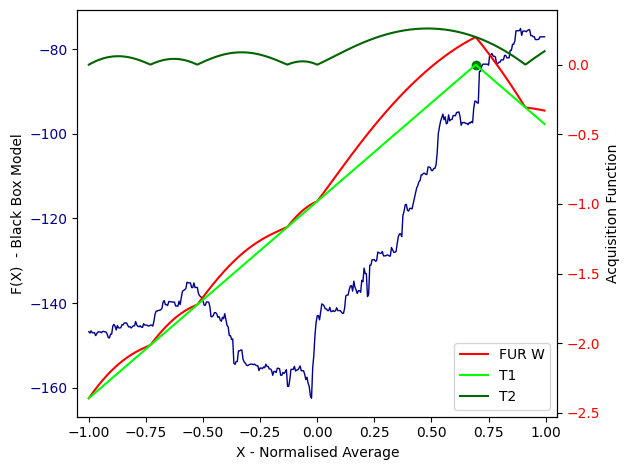

In [34]:
acq_data.plot_point(5)

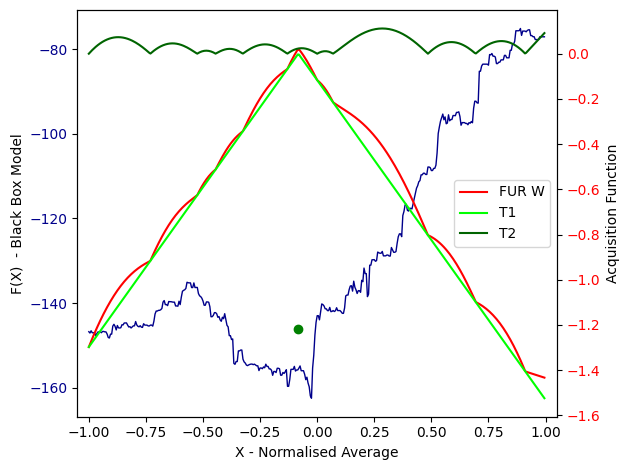

In [35]:
acq_data.plot_point(10)

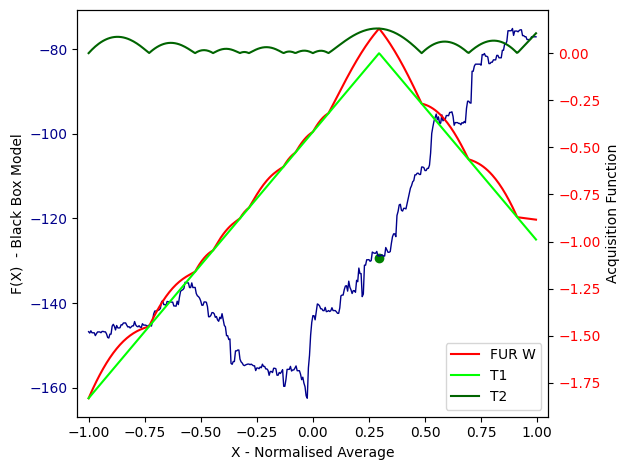

In [36]:
acq_data.plot_point(15)

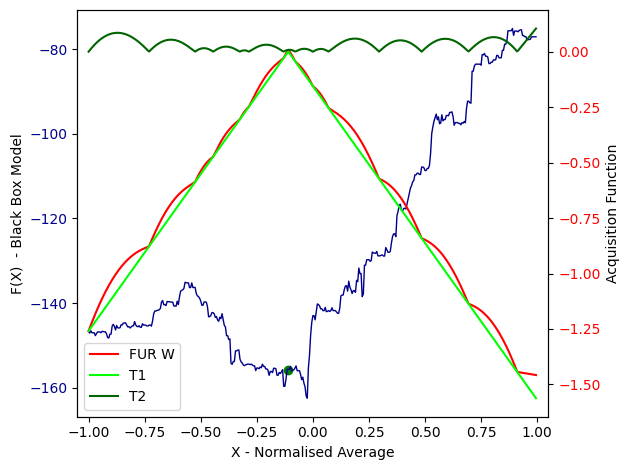

In [37]:
acq_data.plot_point(19)

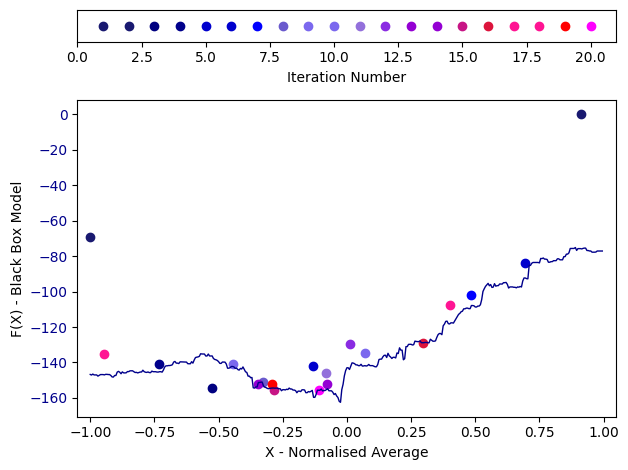

In [38]:
acq_data.plot_all()

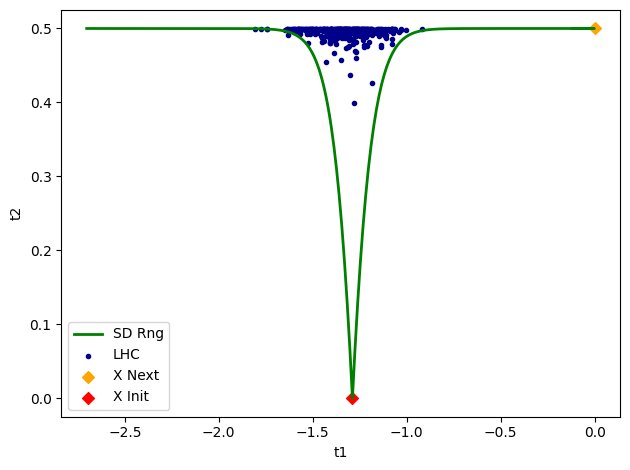

In [39]:
acq_data.plot_t1_t2(0)

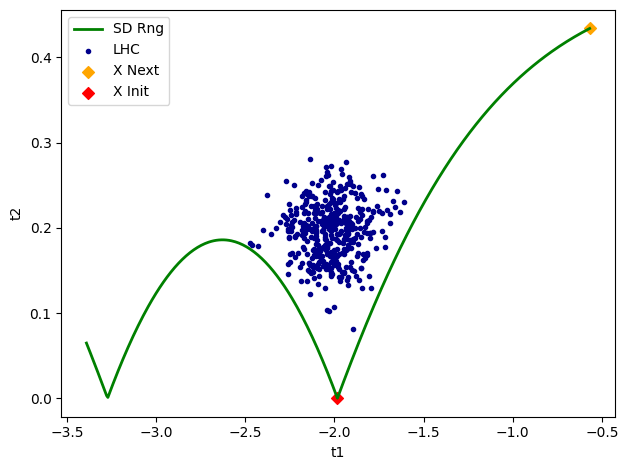

In [40]:
acq_data.plot_t1_t2(1)

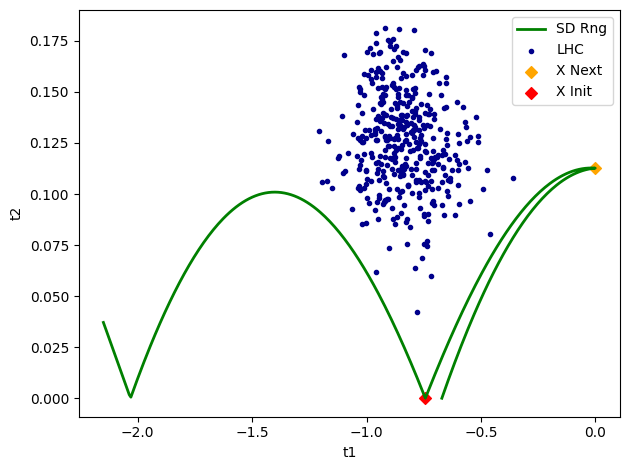

In [41]:
acq_data.plot_t1_t2(2)

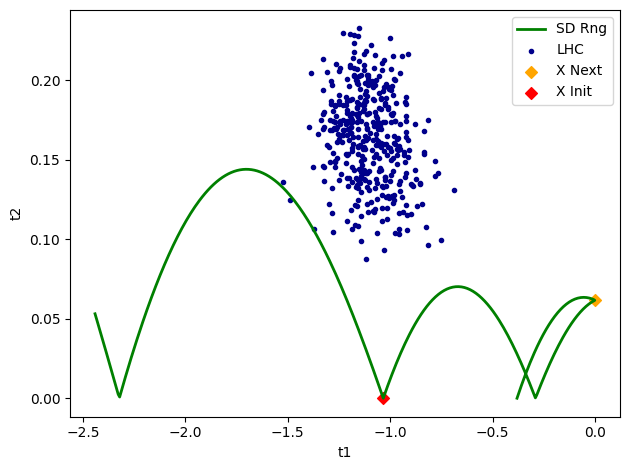

In [42]:
acq_data.plot_t1_t2(3)

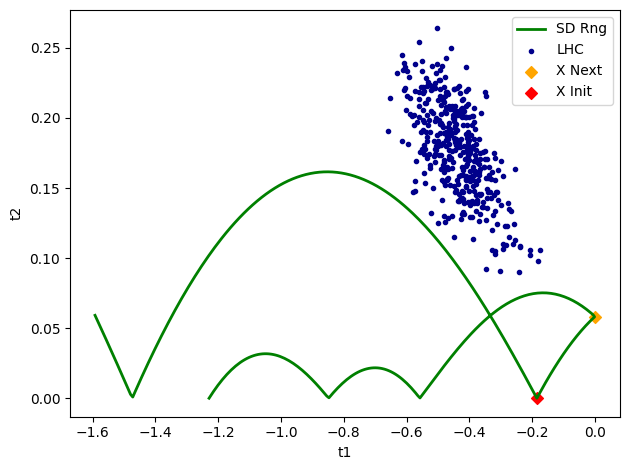

In [43]:
acq_data.plot_t1_t2(4)

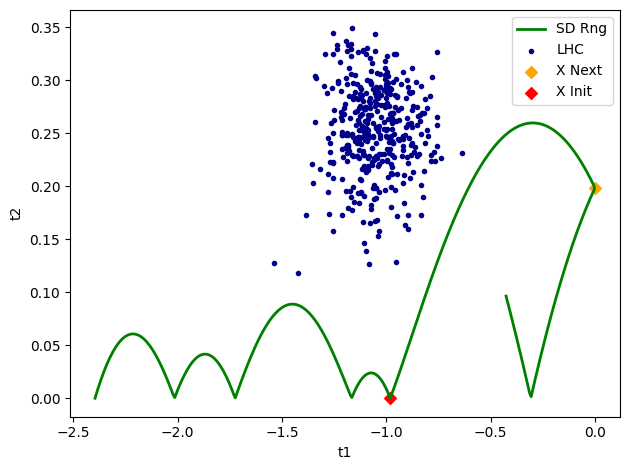

In [44]:
acq_data.plot_t1_t2(5)

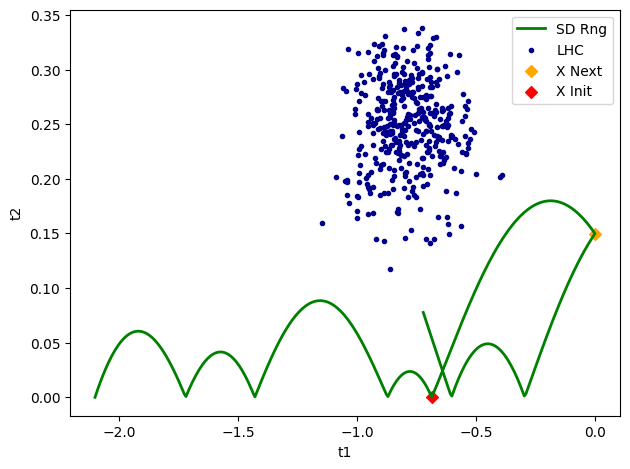

In [45]:
acq_data.plot_t1_t2(6)

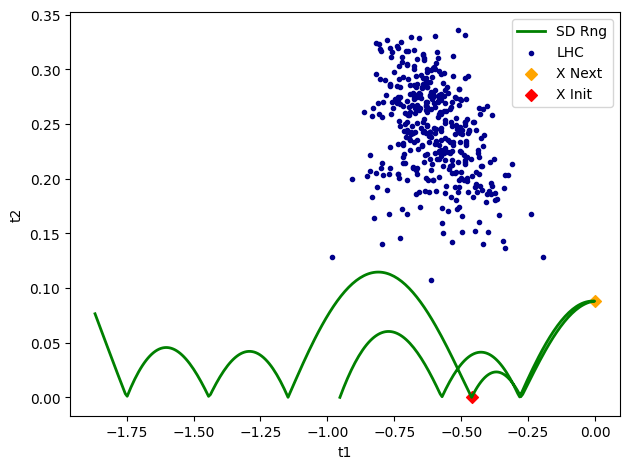

In [46]:
acq_data.plot_t1_t2(7)

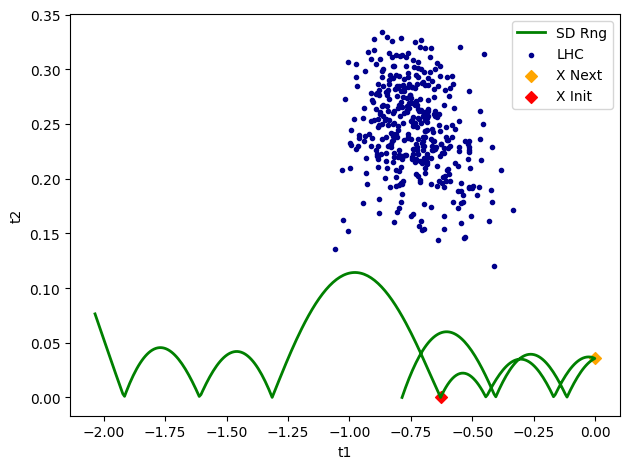

In [47]:
acq_data.plot_t1_t2(8)

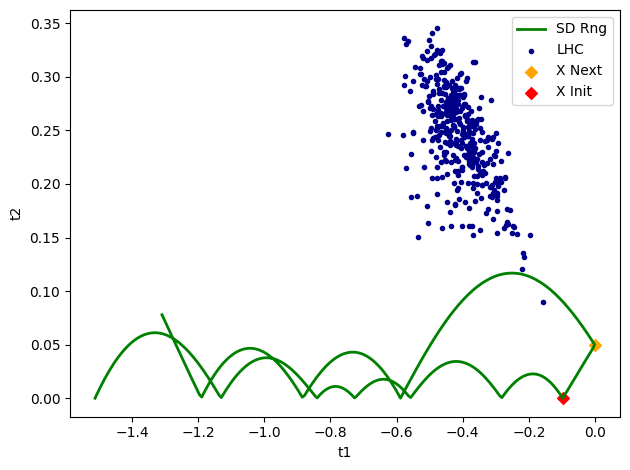

In [48]:
acq_data.plot_t1_t2(9)

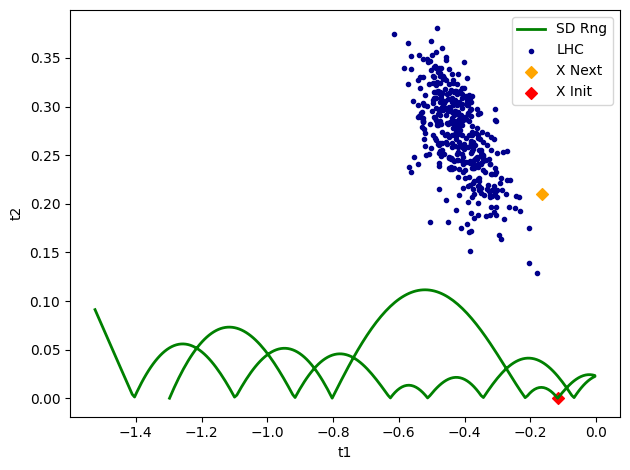

In [49]:
acq_data.plot_t1_t2(10)

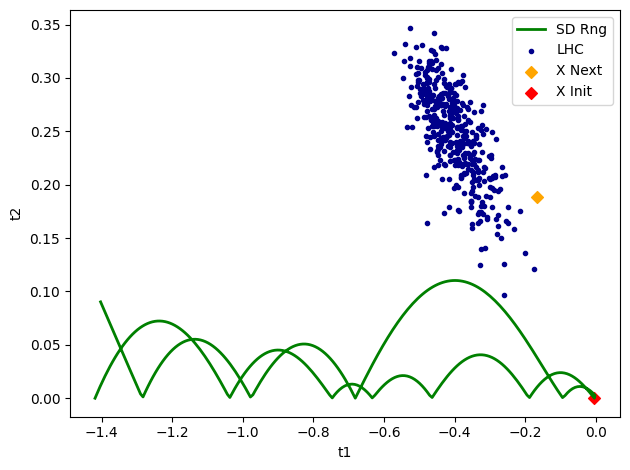

In [50]:
acq_data.plot_t1_t2(11)

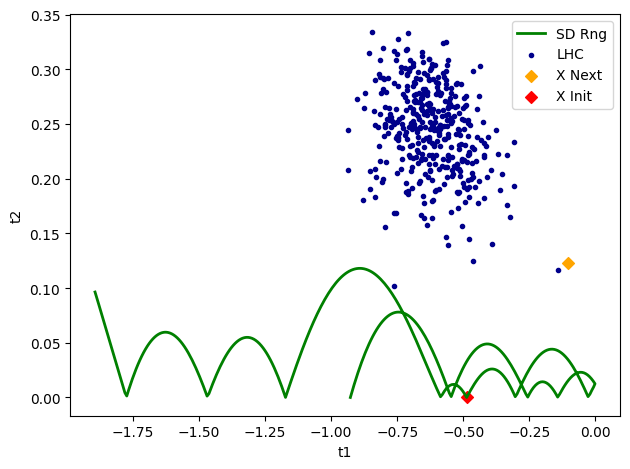

In [51]:
acq_data.plot_t1_t2(12)

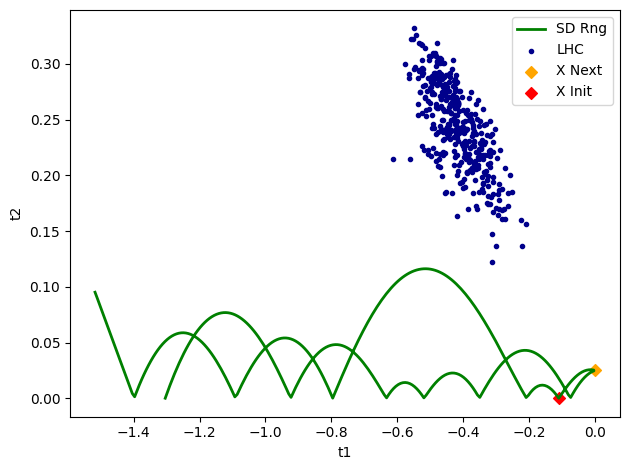

In [52]:
acq_data.plot_t1_t2(13)

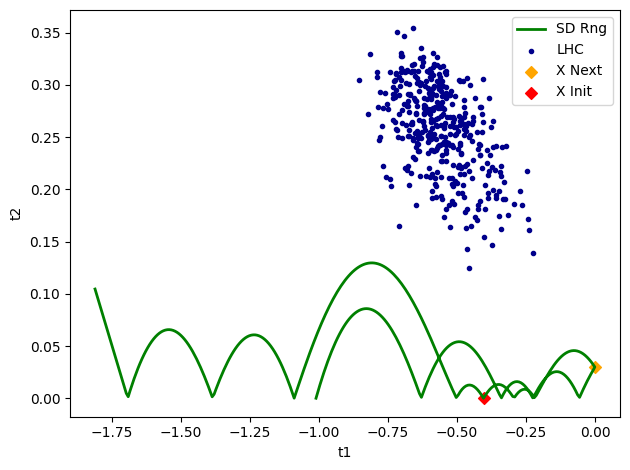

In [53]:
acq_data.plot_t1_t2(14)

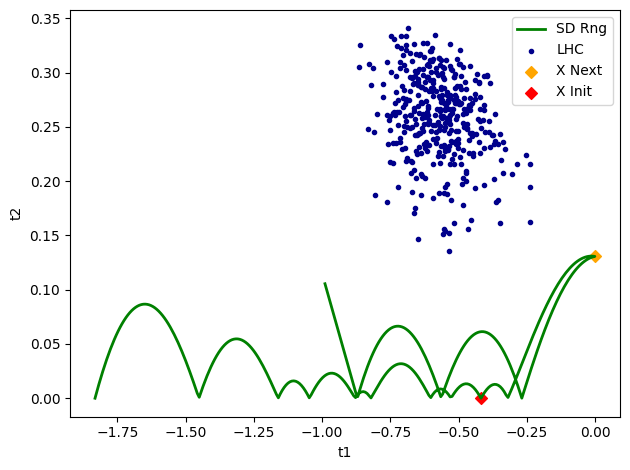

In [54]:
acq_data.plot_t1_t2(15)

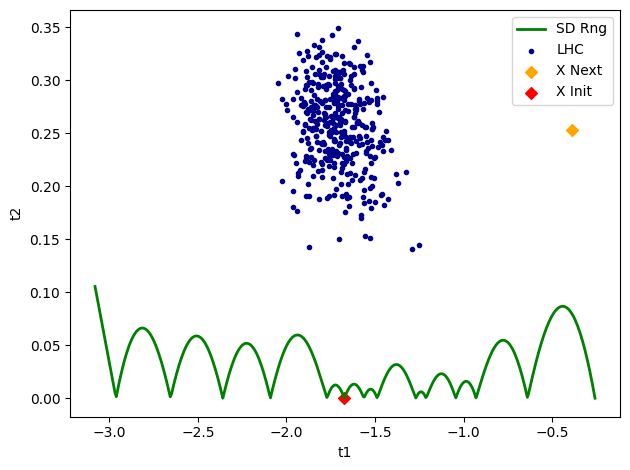

In [55]:
acq_data.plot_t1_t2(16)

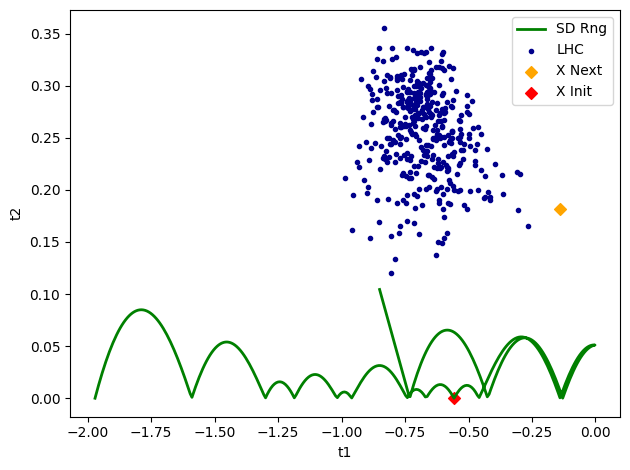

In [56]:
acq_data.plot_t1_t2(17)

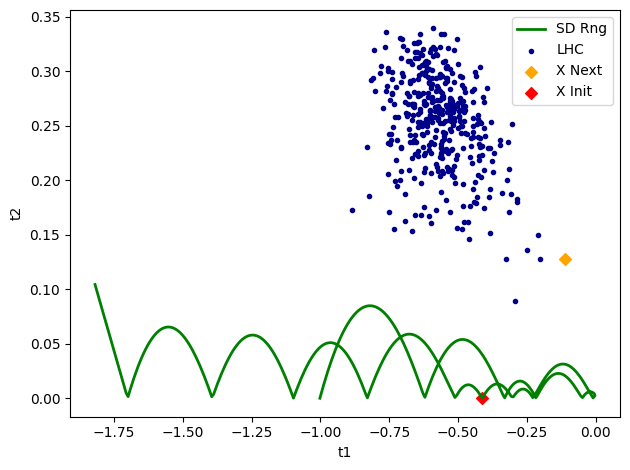

In [57]:
acq_data.plot_t1_t2(18)

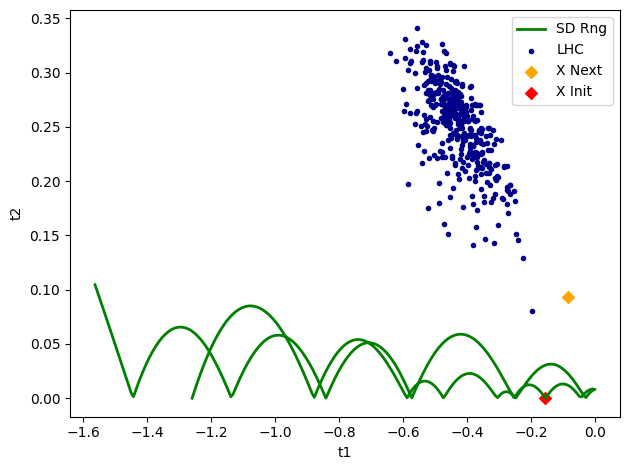

In [58]:
acq_data.plot_t1_t2(19)

Average, SD, and Max Differences:
y - BB(x):           48.90189113530998  :  25.93958523982716  :  85.81976827845894
y - exp(x):          48.90189112531823  :  25.939585179638414  :  85.81976827716412
BB(x) - exp(x):      7.174392351316783e-08  :  6.766522892416754e-08  :  1.8390122136224818e-07
Average exp(x) Uncertainty:  1.0000000413701846e-05
R Score:   1.0
Fidelity:  1.0


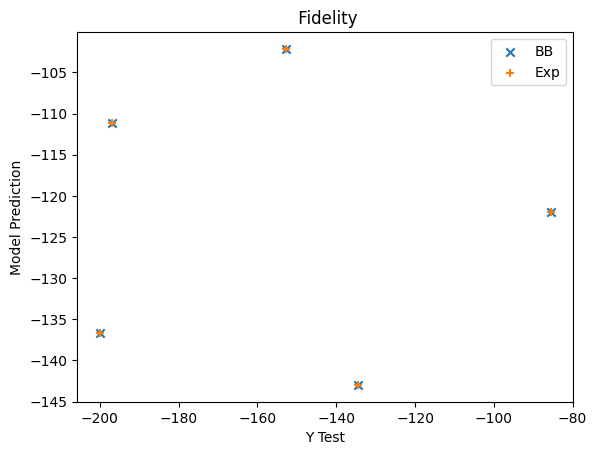

Fidelity:  0.9999999997409266


In [59]:
Reg_Stats.Fidelity()

print('Fidelity: ', Reg_Stats.fidelity)

In [60]:
Reg_Stats.Jaccard_Values(top_k=4)

print('Jaccard: ', Reg_Stats.jaccard_similarities)

Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0
Jaccard:  1.0


In [61]:
Reg_Stats.add_Feature_Coeffs(Feature_Coeffs = Reg_Data.get_Feature_Coeffs())
        
print('Coeff Ratio: ', Reg_Stats.coeffs_ratio)

Mean Coeffs Ratio:  [  0.           0.           4.4941132  -29.59459504  -2.36286638
  28.63841395  24.95198814  -1.46817736]
Feature Coeff Correlation:  -0.3003165136935333
Coeff Ratio:  [  0.           0.           4.4941132  -29.59459504  -2.36286638
  28.63841395  24.95198814  -1.46817736]


In [62]:
delete_1_var = Reg_Stats.delete_one()


mean_variance [121.52522252 121.50696095 119.32797716 122.10266834  83.9863292
  67.20858313 104.82740328 119.25619148]
Mean scores: [414.22267194 162.95335158 342.19115733  85.34766324 518.91612376
 108.75936829  74.25007731 424.04944847]
sort_order [6 3 5 1 2 0 7 4]
norm sorted_scores [0.27878324 0.32045082 0.40835363 0.61183321 1.28480888 1.55526219
 1.59215832 1.94834972]
norm sorted_variance [0.97543202 1.13618051 0.62538422 1.13063738 1.11036166 1.1308073
 1.10969369 0.78150323]
Prediction Variance Feature Deletion 1: [121.52522252 121.50696095 119.32797716 122.10266834  83.9863292
  67.20858313 104.82740328 119.25619148]
Delete 1 error: 0.5620533061786869
Delete 1 Correlation: 0.06360022865247628


Consistancey Std/Y Pert:  0.3 : 0.004891350872489451
Y Perturbed Means: 0.04283125177087418 0.044359917688529114 -0.04000106464344672 -0.033048550025895275
Y Uncertainty Means: 0.011144937332886153 0.02428850794599853 0.1037897787282379 0.009074678592133657


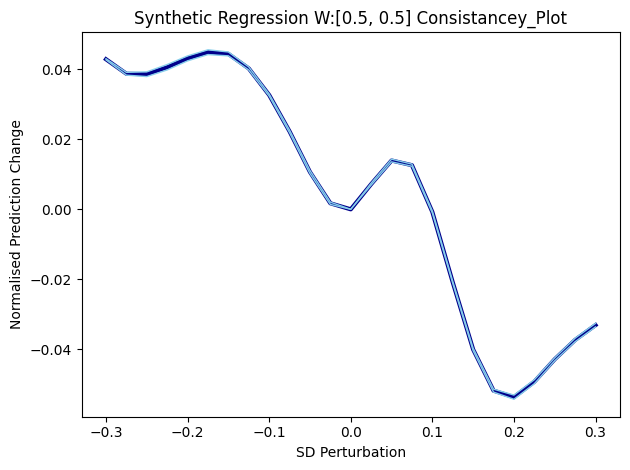

In [63]:
Reg_Stats.Consistancy(std_bound = consist_bound, plot=True, title = Title)

In [64]:
Reg_Stats.Compare_Models (model_b = Reg_Stats_2)

mean_scores:  [414.22267194 162.95335158 342.19115733  85.34766324 518.91612376
 108.75936829  74.25007731 424.04944847]
mean_scores_d:  [ 2.33011126  0.49741482  1.48713001  0.2045332  12.89001629  0.28316571
  0.17027532  2.14936353]
Score Diff Mean:  [0.98881241 0.99391358 0.9913458  0.99521852 0.95152363 0.99480633
 0.99542396 0.9899138 ]
Score Diff SD:    [0.40467036 0.54360822 0.47489924 0.58925201 0.4454759  0.57434849
 0.59683249 0.37531715]
 Model Feature Correlation:  0.7278022168346291


Calibration MSE/MAE 0.94051416907971 0.7838707064334428


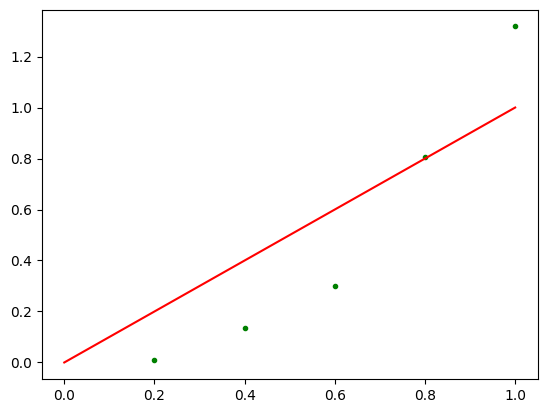

In [65]:
Reg_Stats.Regression_Calibration(plot=True, title=Title)

In [66]:
print(Reg_Stats.calibration_MAE)

0.7838707064334428


In [67]:
Reg_Stats.Regression_Calibration_2(plot=True, title=Title)

root_mean_squared_calibration_error:  0.5669719914221857
mean_absolute_calibration_error:  0.488


In [68]:
Reg_Stats.delete_one()

mean_variance [121.52522252 121.50696095 119.32797716 122.10266834  83.9863292
  67.20858313 104.82740328 119.25619148]
Mean scores: [414.22267194 162.95335158 342.19115733  85.34766324 518.91612376
 108.75936829  74.25007731 424.04944847]
sort_order [6 3 5 1 2 0 7 4]
norm sorted_scores [0.27878324 0.32045082 0.40835363 0.61183321 1.28480888 1.55526219
 1.59215832 1.94834972]
norm sorted_variance [0.97543202 1.13618051 0.62538422 1.13063738 1.11036166 1.1308073
 1.10969369 0.78150323]
Prediction Variance Feature Deletion 1: [121.52522252 121.50696095 119.32797716 122.10266834  83.9863292
  67.20858313 104.82740328 119.25619148]
Delete 1 error: 0.5620533061786869
Delete 1 Correlation: 0.06360022865247628


In [69]:
Reg_Stats.Results_Summary(Title)

Results_Summary: Synthetic Regression W:[0.5, 0.5]
 Model Feature Correlation:  0.7278022168346291
R Score:   1.0
Fidelity:  1.0
Consistancey Std/Y Pert:  0.3 : 0.004891350872489451
Delete 1 error:       0.5620533061786869
Delete 1 Correlation: 0.06360022865247628
Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0
Calibration MSE/MAE:  0.94051416907971 : 0.7838707064334428
 Model Feature Correlation:  0.7278022168346291
Mean Coeffs Error:  -0.3003165136935333
